In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.preprocessing import Normalizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Import and process the dataset 

In [2]:
# Import the data
train_df = pd.read_csv("/Users/aa/Desktop/Umich/Stats 507/jigsaw-toxic-comment-classification-challenge/train.csv")
test_df = pd.read_csv("/Users/aa/Desktop/Umich/Stats 507/jigsaw-toxic-comment-classification-challenge/test.csv")
sample_submission_df = pd.read_csv("/Users/aa/Desktop/Umich/Stats 507/jigsaw-toxic-comment-classification-challenge/sample_submission.csv")
test_labels_df = pd.read_csv("/Users/aa/Desktop/Umich/Stats 507/jigsaw-toxic-comment-classification-challenge/test_labels.csv")

In [3]:
#Remove extra characters in the comment text and lemmatize the comment texts
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text)

    # Remove \n
    text = text.replace('\\n', ' ')
    
    # Remove = signs
    text = re.sub(r'=+', '', text)
    
    # Remove non-English characters 
    text = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', text)
    
    # Remove @ mentions
    text = re.sub(r'@\w+', '', text)
    
    # Remove quotes
    text = text.replace('"', '').replace("'", '')
    
    # Clean up extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize and lemmatize
    tokens = text.split()
    lemmatized = [lemmatizer.lemmatize(token.lower()) for token in tokens]
    text = ' '.join(lemmatized)
    
    return text

train_df["comment_text"] = train_df["comment_text"].apply(clean_text)
test_df["comment_text"] = test_df["comment_text"].apply(clean_text)
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww! he match this background colour im seemi...,0,0,0,0,0,0
2,000113f07ec002fd,"hey man, im really not trying to edit war. it ...",0,0,0,0,0,0
3,0001b41b1c6bb37e,more i cant make any real suggestion on improv...,0,0,0,0,0,0
4,0001d958c54c6e35,"you, sir, are my hero. any chance you remember...",0,0,0,0,0,0


## Data  Characteristics and Visualization

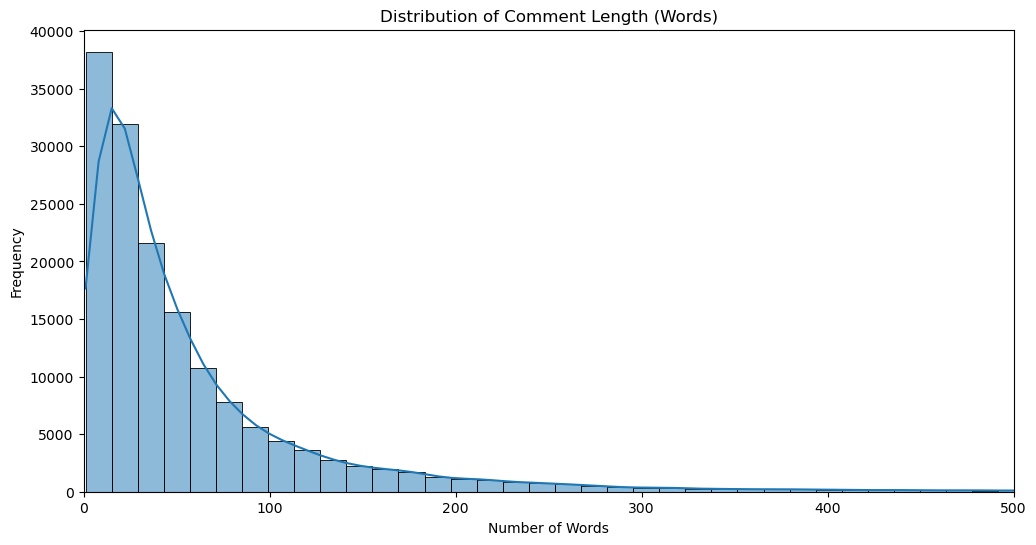


Comment Length Statistics (Words):
count    159571.000000
mean         66.271979
std          98.423116
min           1.000000
25%          16.000000
50%          35.000000
75%          74.000000
max        1403.000000
Name: comment_length, dtype: float64


In [4]:
#Plot the distribution of comment length
train_df['comment_length'] = train_df['comment_text'].apply(lambda x: len(x.split()))
test_df['comment_length'] = test_df['comment_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.histplot(train_df['comment_length'], bins=100, kde=True)
plt.title('Distribution of Comment Length (Words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xlim(0, 500)
plt.show()

print("\nComment Length Statistics (Words):")
print(train_df['comment_length'].describe())

In [5]:
# Calculate label counts and percentages
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
label_counts = train_df[label_cols].sum()
label_percentages = (label_counts / len(train_df)) * 100
label_stats_df = pd.DataFrame({'count': label_counts, 'percentage': label_percentages})
print("Label Distribution:")
print(label_stats_df)

Label Distribution:
               count  percentage
toxic          15294    9.584448
severe_toxic    1595    0.999555
obscene         8449    5.294822
threat           478    0.299553
insult          7877    4.936361
identity_hate   1405    0.880486


In [6]:
# Check for comments with no labels (clean comments)
no_label_count = len(train_df[train_df[label_cols].sum(axis=1) == 0])
print(f"\nNumber of comments with NO toxicity labels: {no_label_count} ({no_label_count / len(train_df) * 100:.2f}%)")


Number of comments with NO toxicity labels: 143346 (89.83%)


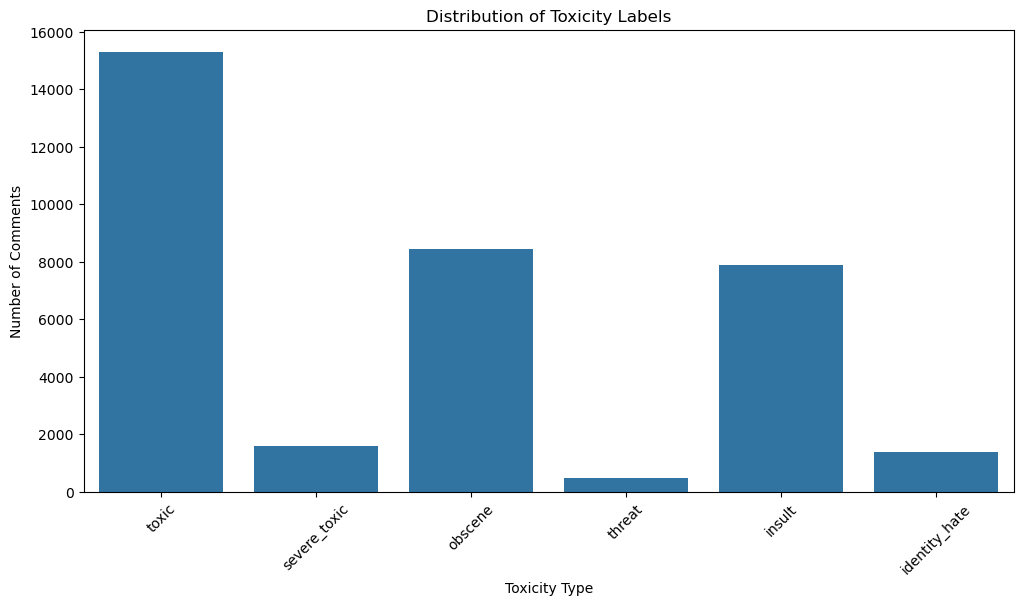

In [7]:
# Plot the Distribution of Toxicity Labels
plt.figure(figsize=(12, 6))
sns.barplot(x=label_stats_df.index, y=label_stats_df['count'])
plt.title('Distribution of Toxicity Labels')
plt.ylabel('Number of Comments')
plt.xlabel('Toxicity Type')
plt.xticks(rotation=45)
plt.show()

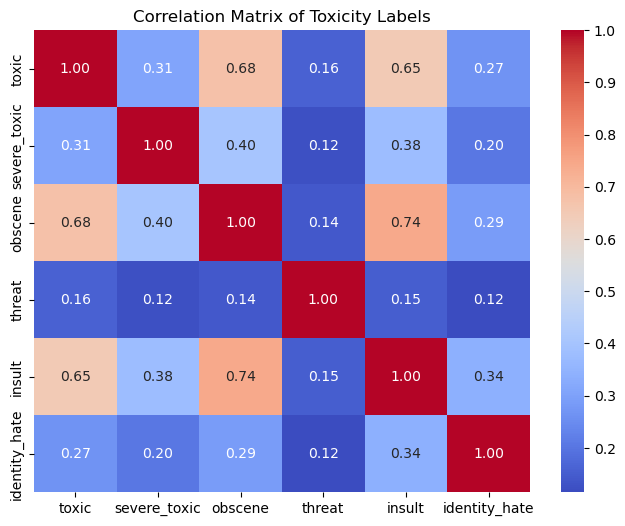

In [8]:
# Multi-label Correlation
plt.figure(figsize=(8, 6))
sns.heatmap(train_df[label_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Toxicity Labels')
plt.show()

## Train  machine learning models 

### Logistic regression model

In [9]:
def ToxicLogistic(train_df, test_df):
    
    # Convert text to TF-IDF features
    vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode',ngram_range=(1, 2))
    
    X_train_tfidf = vectorizer.fit_transform(train_df['comment_text'])
    X_test_tfidf = vectorizer.transform(test_df['comment_text'])
    
    # Create DataFrame for predictions
    test_predictions = pd.DataFrame()
    test_predictions['comment_text'] = test_df['comment_text']
    
    # Initialize metrics storage
    accuracies = []
    f1_scores = []
    precisions = []
    recalls = []
    
    # Train logistic regression model
    for label in label_cols:
        model = LogisticRegression(
            max_iter=1000, 
            random_state=42
        )
        model.fit(X_train_tfidf, train_df[label])
        
        # Calculate metrics on training data
        train_pred = model.predict(X_train_tfidf)
        
        # Store metrics
        accuracies.append(accuracy_score(train_df[label], train_pred))
        f1_scores.append(f1_score(train_df[label], train_pred))
        precisions.append(precision_score(train_df[label], train_pred))
        recalls.append(recall_score(train_df[label], train_pred))
        
        # Make predictions on test data
        y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]
        test_predictions[f'{label}_pred'] = (y_pred_proba >= 0.5).astype(int)
    
    # Model Evaluation
    print("\nModel Evaluation:")
    print(f"Accuracy:  {np.mean(accuracies):.4f}")
    print(f"F1-Score:  {np.mean(f1_scores):.4f}")
    print(f"Precision: {np.mean(precisions):.4f}")
    print(f"Recall:    {np.mean(recalls):.4f}")
    
    return test_predictions


test_predictions_1 = ToxicLogistic(train_df, test_df)
test_predictions_1.head()


Model Evaluation:
Accuracy:  0.9825
F1-Score:  0.5113
Precision: 0.7918
Recall:    0.4028


,comment_text,toxic_pred,severe_toxic_pred,obscene_pred,threat_pred,insult_pred,identity_hate_pred
0,yo bitch ja rule is more succesful then youll ...,1,0,1,0,1,0
1,"from rfc the title is fine a it is, imo.",0,0,0,0,0,0
2,source zawe ashton on lapland,0,0,0,0,0,0
3,"if you have a look back at the source, the inf...",0,0,0,0,0,0
4,i dont anonymously edit article at all.,0,0,0,0,0,0


### SVM with LSA model

In [10]:
class ToxicSVM:
    def __init__(self, 
                 n_estimators=5,    
                 sample_size=20000,  
                 max_features=10000,   
                 n_components=100):  
        
        self.n_estimators = n_estimators
        self.sample_size = sample_size
        self.max_features = max_features
        self.n_components = n_components
        self.models = []
        self.label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        
    def create_pipeline(self):
        return Pipeline([
            ('vectorizer', TfidfVectorizer(
                max_features=self.max_features,
                strip_accents='unicode'    
            )),
            ('lsa', TruncatedSVD(n_components=self.n_components)),
            ('classifier', LinearSVC(
                max_iter=1000,
                class_weight='balanced'
            ))
        ])
    
    def train_model(self, train_df, label):
        sample_df = train_df.sample(n=min(self.sample_size, len(train_df)), 
                                  replace=False)
        
        model = self.create_pipeline()
        model.fit(sample_df['comment_text'], sample_df[label])
        
        train_pred = model.predict(sample_df['comment_text'])
        metrics = {
            'accuracy': accuracy_score(sample_df[label], train_pred),
            'f1': f1_score(sample_df[label], train_pred),
            'precision': precision_score(sample_df[label], train_pred),
            'recall': recall_score(sample_df[label], train_pred)
        }
        
        return model, metrics
    
    def fit(self, train_df):
        all_metrics = {
            'accuracy': [],
            'f1': [],
            'precision': [],
            'recall': []
        }
        
        for i in tqdm(range(self.n_estimators), desc="Training Models"):
            models_for_labels = {}
            for label in self.label_cols:
                model, metrics = self.train_model(train_df, label)
                models_for_labels[label] = model
                
                # Accumulate metrics
                for metric_name, value in metrics.items():
                    all_metrics[metric_name].append(value)
                    
            self.models.append(models_for_labels)
        
        # Model Evaluation
        print("\nModel Evaluation:")
        print(f"Accuracy:  {np.mean(all_metrics['accuracy']):.4f}")
        print(f"F1-Score:  {np.mean(all_metrics['f1']):.4f}")
        print(f"Precision: {np.mean(all_metrics['precision']):.4f}")
        print(f"Recall:    {np.mean(all_metrics['recall']):.4f}")
    
    def predict(self, test_df):
        predictions = pd.DataFrame()
        predictions['comment_text'] = test_df['comment_text']
        
        for label in self.label_cols:
            label_predictions = []
            for model_set in self.models:
                model = model_set[label]
                pred = model.predict(test_df['comment_text'])
                label_predictions.append(pred)
            
            ensemble_pred = np.mean(label_predictions, axis=0) > 0.5
            predictions[f'{label}_pred'] = ensemble_pred.astype(int)
        
        return predictions

In [11]:
# Initialize and train classifier
classifier = ToxicSVM(
    n_estimators=5,     
    sample_size=20000,  
    max_features=10000, 
    n_components=100 
)


classifier.fit(train_df)
predictions = classifier.predict(test_df)
predictions.head()

Training Models: 100%|████████████████████████████| 5/5 [02:20<00:00, 28.20s/it]



Model Evaluation:
Accuracy:  0.9094
F1-Score:  0.3385
Precision: 0.2334
Recall:    0.9016


,comment_text,toxic_pred,severe_toxic_pred,obscene_pred,threat_pred,insult_pred,identity_hate_pred
0,yo bitch ja rule is more succesful then youll ...,1,1,1,1,1,1
1,"from rfc the title is fine a it is, imo.",0,0,0,0,0,0
2,source zawe ashton on lapland,0,0,0,0,0,0
3,"if you have a look back at the source, the inf...",0,0,0,0,0,0
4,i dont anonymously edit article at all.,0,0,0,0,0,0


In [12]:
class ToxicRandomForest:

    def __init__(self,
                n_estimators=3,      
                sample_size=10000,  
                n_features=10000,   
                trees_per_model=100):
        
        self.n_estimators = n_estimators
        self.sample_size = sample_size
        self.n_features = n_features
        self.trees_per_model = trees_per_model
        self.models = []
        self.vectorizers = []
        self.label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    
    def train_model(self, train_df, label):

        sample_df = train_df.sample(n=min(self.sample_size, len(train_df)), 
                                  replace=False)
        
        # Create and fit vectorizer
        vectorizer = TfidfVectorizer(
            max_features=self.n_features, 
            strip_accents='unicode',
            ngram_range=(1, 2)
        )
        X = vectorizer.fit_transform(sample_df['comment_text'])
        
        # Initialize and train model
        model = RandomForestClassifier(
            n_estimators=self.trees_per_model,
            n_jobs=-1,
            random_state=42
        )
        model.fit(X, sample_df[label])
        
        # Calculate evaluation metrics
        predictions = model.predict(X)
        metrics = {
            'accuracy': accuracy_score(sample_df[label], predictions),
            'f1': f1_score(sample_df[label], predictions),
            'precision': precision_score(sample_df[label], predictions),
            'recall': recall_score(sample_df[label], predictions)
        }
        
        return model, vectorizer, metrics
    
    def fit(self, train_df):

        all_metrics = {
            'accuracy': [],
            'f1': [],
            'precision': [],
            'recall': []
        }
        
        for i in tqdm(range(self.n_estimators), desc="Training Models"):
            models_for_labels = {}
            vectorizers_for_labels = {}
            
            for label in self.label_cols:
                model, vectorizer, metrics = self.train_model(train_df, label)
                models_for_labels[label] = model
                vectorizers_for_labels[label] = vectorizer
                
                for metric_name, value in metrics.items():
                    all_metrics[metric_name].append(value)
            
            self.models.append(models_for_labels)
            self.vectorizers.append(vectorizers_for_labels)
        
        # Model Evaluation
        print("\nModel Evaluation:")
        print(f"Accuracy:  {np.mean(all_metrics['accuracy']):.4f}")
        print(f"F1-Score:  {np.mean(all_metrics['f1']):.4f}")
        print(f"Precision: {np.mean(all_metrics['precision']):.4f}")
        print(f"Recall:    {np.mean(all_metrics['recall']):.4f}")
    
    def predict(self, test_df):

        predictions = pd.DataFrame()
        predictions['comment_text'] = test_df['comment_text']
        
        for label in self.label_cols:
            label_predictions = []
            
            for model_idx in range(len(self.models)):
                model = self.models[model_idx][label]
                vectorizer = self.vectorizers[model_idx][label]
                
                X_test = vectorizer.transform(test_df['comment_text'])
                pred = model.predict_proba(X_test)[:, 1]
                label_predictions.append(pred)
            
            ensemble_pred = np.mean(label_predictions, axis=0) > 0.5
            predictions[f'{label}_pred'] = ensemble_pred.astype(int)
        
        return predictions


In [14]:
# Initialize and train classifier
classifier = ToxicRandomForest(
    n_estimators=3,
    sample_size=10000,
    n_features=10000,   
    trees_per_model=100   
)

classifier.fit(train_df)
predictions = classifier.predict(test_df)
predictions.head(10)

Training Models: 100%|████████████████████████████| 3/3 [01:17<00:00, 25.81s/it]



Model Evaluation:
Accuracy:  0.9999
F1-Score:  0.9969
Precision: 0.9990
Recall:    0.9948


,comment_text,toxic_pred,severe_toxic_pred,obscene_pred,threat_pred,insult_pred,identity_hate_pred
0,yo bitch ja rule is more succesful then youll ...,1,0,1,0,1,0
1,"from rfc the title is fine a it is, imo.",0,0,0,0,0,0
2,source zawe ashton on lapland,0,0,0,0,0,0
3,"if you have a look back at the source, the inf...",0,0,0,0,0,0
4,i dont anonymously edit article at all.,0,0,0,0,0,0
5,thank you for understanding. i think very high...,0,0,0,0,0,0
6,please do not add nonsense to wikipedia. such ...,0,0,0,0,0,0
7,dear god this site is horrible.,0,0,0,0,0,0
8,only a fool can believe in such numbers. the c...,0,0,0,0,0,0
9,"double redirects when fixing double redirects,...",0,0,0,0,0,0
